# Compute and Compare FPTs

# Importations

In [1]:
import numpy as np

import sys
import time
from tqdm import tqdm
import copy
from scipy.io import savemat, loadmat

from scipy.optimize import curve_fit

# from multiprocessing import Pool

from numba import njit

In [2]:
# import simulations.langevin.ComputeObservables as co

In [ ]:
from FirstPassageTime import *

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpltools import annotation
from matplotlib import rc
import seaborn as sns
# custom_params = {
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "lines.markeredgecolor": "k",
#     "lines.markeredgewidth": 0.3,
#     "lines.linewidth": 1.5, 
#     "xtick.direction": "in",
#     "xtick.labelsize": 9,
#     "ytick.direction": "in",
#     "ytick.labelsize": 9, 
#     "font.size": 9, 
#     "font.family": "serif",
#     "figure.dpi": 500,
#     "text.usetex": True,
# }
# sns.set_theme(context = "notebook", style="ticks", rc=custom_params)
rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.3)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)
rc('font', family='serif', size=9)
rc('text', usetex=True)
rc('figure', dpi=500)
rc('savefig', dpi=500)

# Auxiliary Functions

In [4]:
def compute_lB(a, drho, kT=4e-21, g=9.81):
    return kT / (4/3*np.pi*a**3*drho*g)

In [5]:
# Here z is the gap between the particle and the (bottom) wall

def diffusing_diffusivity_z(z, a):
    res = (6*(z**2) + 2*a*z) / (6*(z**2) + 9*a*z + 2*(a**2))
    return res

def diffusing_diffusivity_x(z, a):
    ksi = a / (a + z)
    res = (1 - (9/16)*(ksi) + (1/8)*(ksi**3) - (45/256)*(ksi**4) + (1/16)*(ksi**5))
    return res

In [6]:
def _P_eq(z, B, lD, lB):
    return np.exp(-B * np.exp(-z / lD) - z / lB)

def P_eq(z, B, lD, lB, normalize=True):
    if type(z) == float:
        if z < 0:
            res = 0
        return _P_eq(z, B, lD, lB)
    res = _P_eq(z, B, lD, lB)
    res[z < 0] = 0
    if normalize:
        res = res / np.trapezoid(res, z) # Ok because it is a change of variable
    return res

In [7]:
def Levy(t, L, D, x0=0):
    res = abs(L - x0) / np.sqrt(4*np.pi*D*t**3) * np.exp(-(L - x0)**2 / (4*D*t)) 
    return res

In [8]:
def logarithmic_hist(data, begin, stop, num=50, base=2, density=True):
    if begin == 0:
        beg = stop / num
        bins = np.logspace(
            np.log(beg) / np.log(base), 
            np.log(stop) / np.log(base), 
            num - 1, 
            base=base, 
        )
        widths = bins[1:] - bins[:-1]
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0], bins))
        widths = bins[1:] - bins[:-1]
    else:
        bins = np.logspace(
            np.log(begin) / np.log(base), 
            np.log(stop) / np.log(base), 
            num, 
            base=base, 
            dtype=np.float64, 
        )
        widths = bins[1:] - bins[:-1]
    hist, bins = np.histogram(data, bins=bins, density=density)
    # hist = hist / np.trapezoid(hist, bins)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1]) / 2
    return bins_center, widths, hist

In [9]:
def find_rn(filepath):
    """
    Find the radius of the particle in the file path. 
    The trajectory (.mat) should be in the last folder considered.
    """
    try:
        filename = filepath[filepath.rfind('/')+1:]
        r = float(filename[filename.find('_rp_')+4:filename.find('_np_')].replace('p','.')) * 1e-6
        n_p = float(filename[filename.find('_np_')+4:filename.find('_vid')].replace('p','.'))
    except:
        print(filepath)
        r = input("Enter the radius in um = ")
        r = float(r) * 1e-6
        n_p = input("Enter the refractive index = ")
        n_p = float(n_p)
    return r, n_p

In [10]:
def str2var(string):
    return globals()[string]

# Load Data

## Experimental Data

In [31]:
# Load several .mat from experimental data

# Get directories 

dir0_0 = './trajs_AR1000_in_water_20250624/traj_rp_2p1711_np_1p4525_vid_confined1.mat'
dir0_1 = './trajs_AR1000_in_water_20250624/traj_rp_2p1825_np_1p4519_vid_confined2.mat'
dir0_2 = './trajs_AR1000_in_water_20250624/traj_rp_2p171_np_1p4527_vid_confined3.mat'
dir0_3 = './trajs_AR1000_in_water_20250624/traj_rp_2p4039_np_1p4529_vid_confined4.mat'

dt_0 = 0.01

dirs0 = [str2var('dir0_{}'.format(i)) for i in range(4)]

# For later, load experimental datas after analysis

# Then get MSDs, PDFs, ...

In [12]:
def mat2traj(dirs, N):
    xs, ys, zs = np.zeros((N, len(dirs))) * np.nan, np.zeros((N, len(dirs))) * np.nan , np.zeros((N, len(dirs))) * np.nan 
    for i, d in enumerate(dirs):
        data = loadmat(d, squeeze_me=True)
        x, y, z = data['x'], data['y'], data['z']
        xs[:,i] = x[:N]
        ys[:,i] = y[:N]
        zs[:,i] = z[:N]
    return xs, ys, zs 

In [13]:
# Group-by procedure and loadmat

xs_0, ys_0, zs_0 = mat2traj(dirs0, 200_000)

In [14]:
xs_0

array([[3.49505939e-05, 3.42674768e-05, 3.28374787e-05, 3.45369361e-05],
       [3.49566791e-05, 3.42279766e-05, 3.28010210e-05, 3.45415664e-05],
       [3.49790044e-05, 3.42305966e-05, 3.28147110e-05, 3.45569145e-05],
       ...,
       [2.61463267e-05, 3.77277926e-05, 3.31983041e-05, 1.88237715e-05],
       [2.61469789e-05, 3.77166928e-05, 3.31950051e-05, 1.88217973e-05],
       [2.61504261e-05, 3.77112173e-05, 3.31475743e-05, 1.88083468e-05]])

## Simulation Data

In [15]:
# Simulations are divided into 2 groups:
# 1/ A few simulations to mimic experiments, that are loaded and analyzed like experimental trajectories
# 2/ Optimal simulations (e.g. huge nb of trajectories) to ensure the best statistics possible.

In [35]:
# 1/
dir_simu_0 = './simu_rigid_like_trajs_AR1000_in_water_20250624.mat'
data = loadmat(dir_simu_0, squeeze_me=True)
xs_s0, zs_s0 = data['xs'][:,:], data['zs'][:,:]
dt_s0 = data['dt']
del data

# To be done: get back PDFs, MSDs, etc., from the simulations

## Initialize Saving

In [36]:
save = {}

# Compute FPTs

In [18]:
Ls = [300e-9]

In [22]:
%%time 

fpt_x_s0 = get_FPT_several_particles(xs_s0, dt_s0, Ls)

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]

L = 0.3 um done.
CPU times: user 9.65 s, sys: 17 ms, total: 9.67 s
Wall time: 9.64 s


In [26]:
k = 0

fpt_x = fpt_x_s0[k][~np.isnan(fpt_x_s0[k])]

bins_FPT_x_s0, _, hist_FPT_x_s0 = logarithmic_hist(fpt_x, begin=np.min(fpt_x), stop=np.max(fpt_x), num=20, base=10, )

In [43]:
def traj2fpt(xs, dt, Ls, num=20, base=10):
    fpt_x = get_FPT_several_particles(xs, dt, Ls)
    if len(Ls) == 1:
        k = 0
        temp_fpt = fpt_x[k][~np.isnan(fpt_x[k])]
        bins_FPT_x, _, hist_FPT_x = logarithmic_hist(fpt_x, begin=np.min(temp_fpt), stop=np.max(temp_fpt), num=num, base=base, )
        return bins_FPT_x, hist_FPT_x
    else:
        bins_FPT_x, hist_FPT_x = [], []
        for k, l in enumerate(Ls):
            temp_fpt = fpt_x[k][~np.isnan(fpt_x[k])]
            bins, _, hist = logarithmic_hist(temp_fpt, begin=np.min(temp_fpt), stop=np.max(temp_fpt), num=num, base=base, ) #traj2fpt(xs, dt, [l], num=num, base=base)
            bins_FPT_x.append(bins)
            hist_FPT_x.append(hist)
        bins_FPT_x, hist_FPT_x = np.array(bins_FPT_x), np.array(hist_FPT_x)
        return bins_FPT_x, hist_FPT_x

In [56]:
bins_FPT_x_0, hist_FPT_x_0 = traj2fpt(xs_0, dt_0, Ls)

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]

L = 0.3 um done.


In [57]:
bins_FPT_x_s0, hist_FPT_x_s0 = traj2fpt(xs_s0, dt_s0, Ls)

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.33it/s]


L = 0.3 um done.


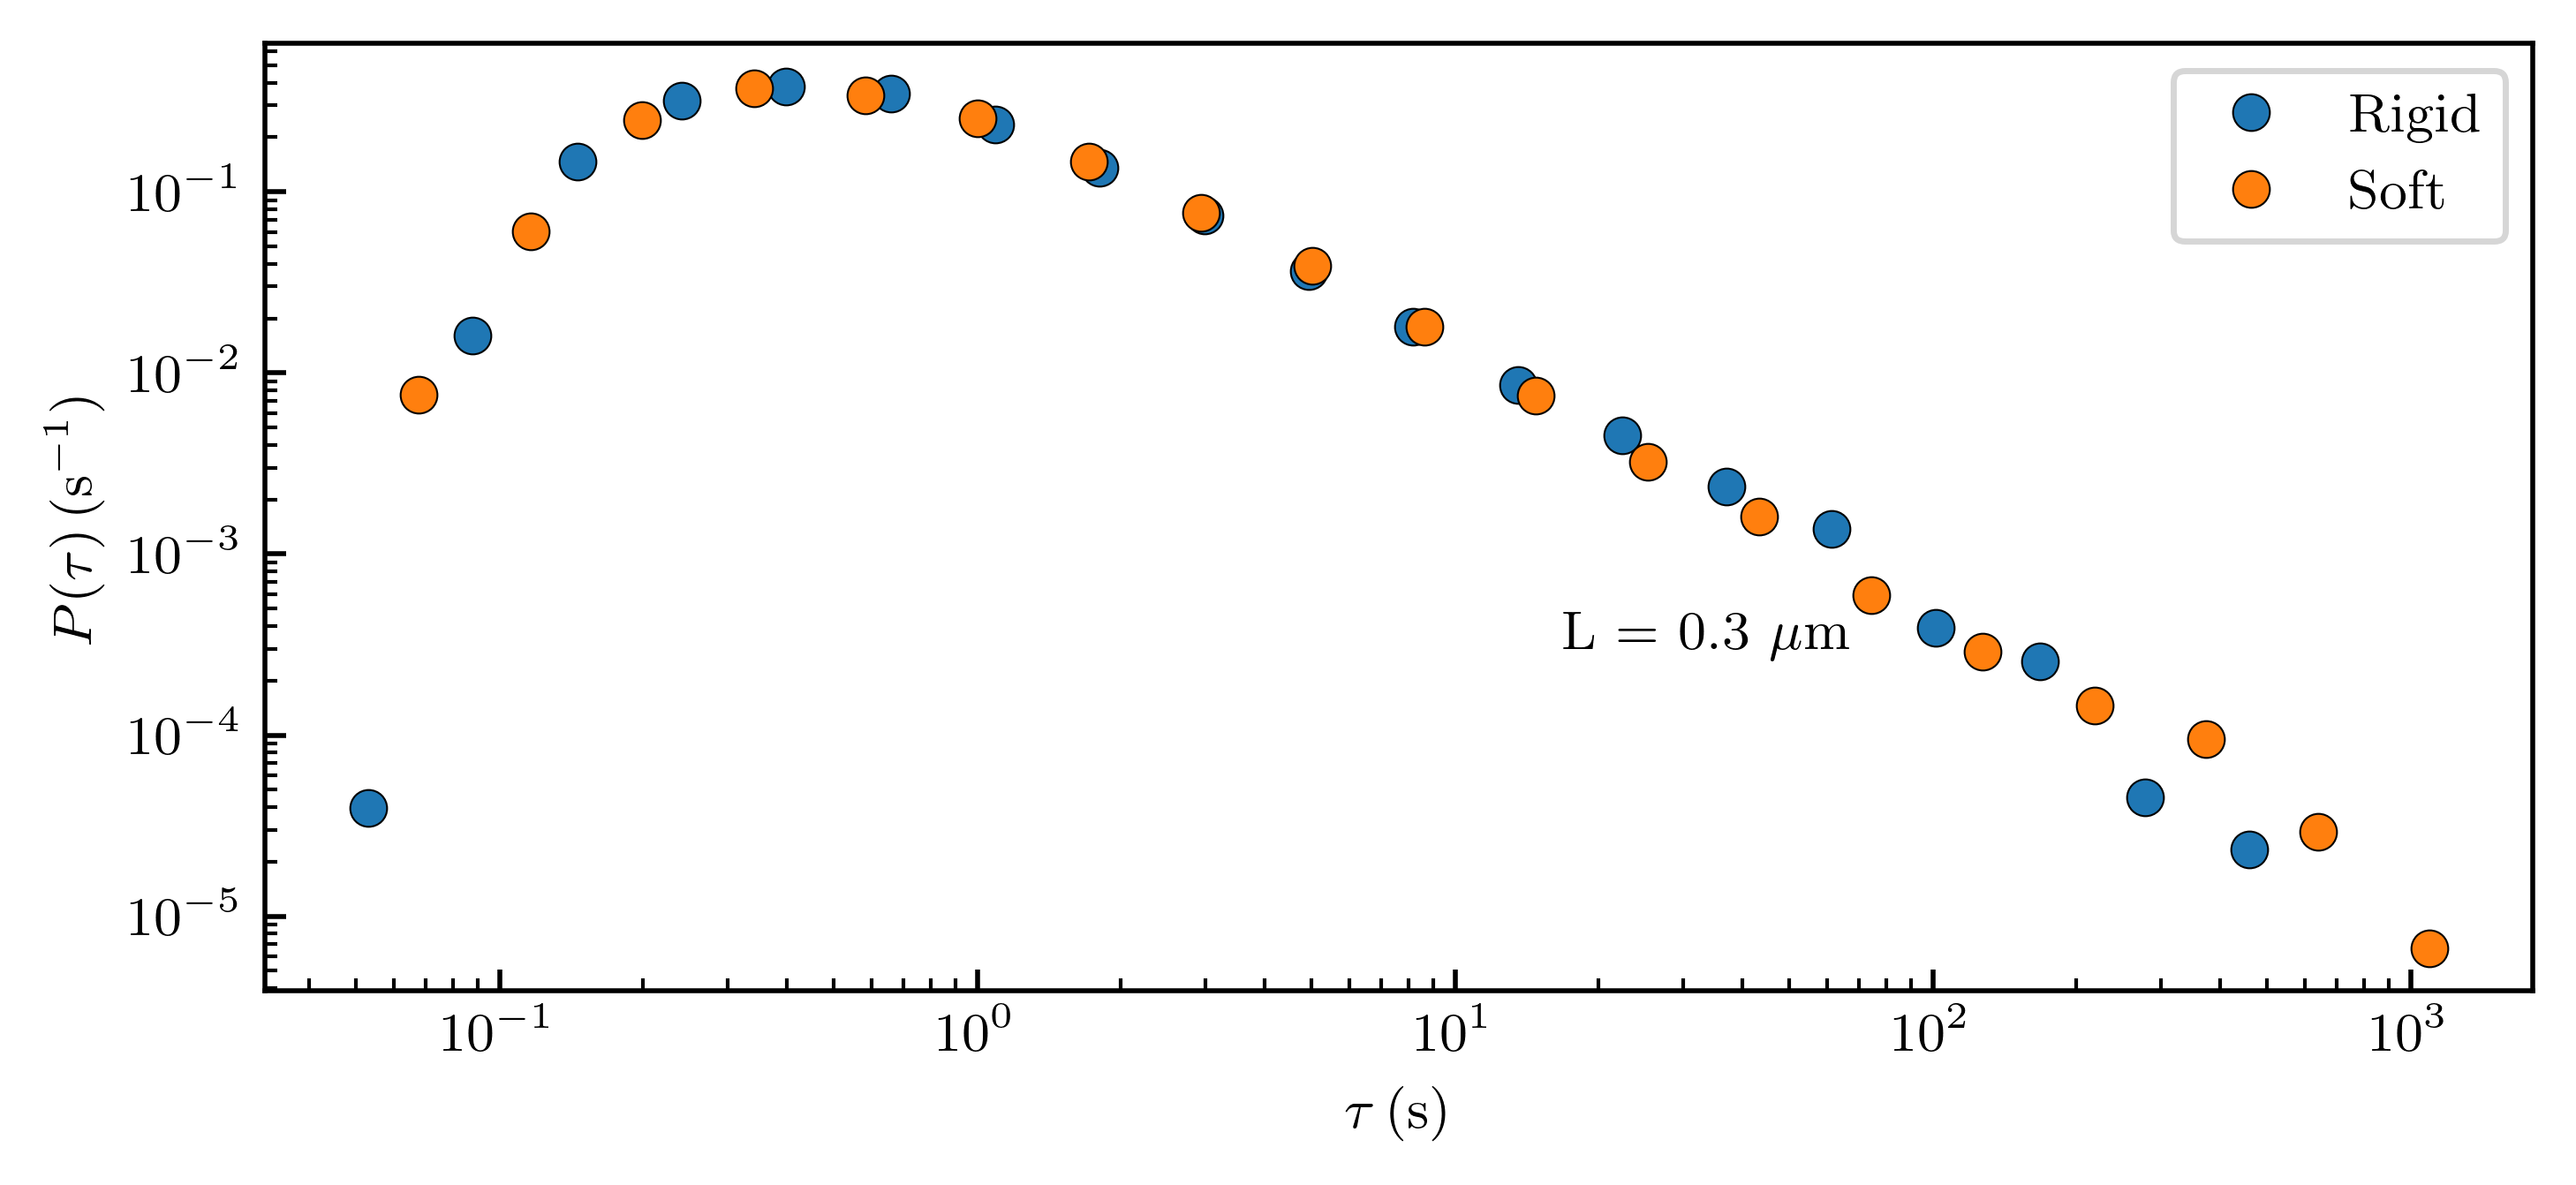

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.loglog(bins_FPT_x_s0, hist_FPT_x_s0, 'o', label='Rigid')
ax.loglog(bins_FPT_x_0, hist_FPT_x_0, 'o', label='Soft')
# ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--', c='tab:red', label=r'Theory', zorder=3)
# ax.plot(bins_FPT_x_theory, hist_FPT_x_fit, '--k', label='Fit')
# ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=Ls[k], D=meanDx_MSD), '-k', label='MSD')
ax.set(xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$')
ax.legend()
ax.annotate(
    r"L = {} $\mu$m".format(np.round(Ls[k] * 1e6, 1)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.4), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()